# Red neuronal para clasificación de imágenes de números escritos a mano

```
Integrantes:
  Choque Bueno Fiorella
  Condori Ccarhuarupay Bruno Moises
  Huaman Guevara Alexander Javier
  Huaraya Chara Bladimir
  Luna Ccasani Charlie Joel
  Tacusi Larota Jhon Edwin
```


In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 44.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ac369be48b74b04e2cd1a641d47af704a263d66c810201340c945da20f8e63bc
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Librerías utilizadas

In [ ]:
import sys
import pyspark
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

#1. Descargar MNIST Dataset de Keras

In [ ]:
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils
# cargar MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# training data : 60000 datos
# reshape y normalizacion de los datos de entrada 
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# codificar la salida que es un numero en el rango [0,9] en un vector de tamaño 10 
# p.ej. el numero 3 se convertira  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# lo mismo para datos de prueba: 10000 muestras 
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# separamos y guardamos el dataset de MNIST
np.savetxt('mnist_images_train.csv', x_train.reshape(len(x_train),784).tolist())
np.savetxt('mnist_images_test.csv', x_test.reshape(len(x_test),784).tolist())
np.savetxt('mnist_labels_train.csv', y_train.tolist())
np.savetxt('mnist_labels_test.csv', y_test.tolist())

In [ ]:
test = pd.read_csv("/content/mnist_labels_train.csv", sep = " ", header = None)
test.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
import pandas as pd
test = pd.read_csv("/content/mnist_images_train.csv", sep = " ", header = None)
test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.576471,0.988235,0.164706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#2. Cargar datos

In [ ]:
#definimos el sparkContext
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName")
sc = SparkContext(conf=conf)

In [ ]:
#cargamos el texto con el pyspark
txt_train_images = sc.textFile("mnist_images_train.csv", 1)
#separamos la data en un pair de indice, imagen del train
x_train = txt_train_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_train_labels = sc.textFile("mnist_labels_train.csv", 1)
#separamos la data en un pair de indice, label del train
y_train = txt_train_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_images = sc.textFile("mnist_images_test.csv", 1)
#separamos la data en un pair de indice, imagen del test
x_test = txt_test_images.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 784)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

txt_test_labels = sc.textFile("mnist_labels_test.csv", 1)
#separamos la data en un pair de indice, label del test
y_test = txt_test_labels.map(lambda x : np.fromstring(x, dtype=float, sep=' ').reshape(1, 10)).zipWithIndex().map(lambda x: (str(x[1]), x[0]))

In [ ]:
# hacer un map en el rdd como imagen, label(lo restringimos para la prediccion de 0 y 1)
train_ds_rdd = x_train.join(y_train).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))
test_ds_rdd = x_test.join(y_test).map(lambda x: x[1]).map(lambda x: (x[0], np.array([x[1][0][:2]])))
# filtrar de acuerdo a los labels  
train_rdd = train_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))
test_rdd = test_ds_rdd.filter(lambda x: np.array_equal(x[1][0], [1., 0.]) or np.array_equal(x[1][0], [0., 1.]))

#guardar en memoria
train_rdd.cache()

print(train_rdd.take(1))
print("Tamaño del Trainset:", train_rdd.count())
print("Tamaño del Testset:", test_rdd.count())

[(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

#3. Funciones

## Funciones de activación
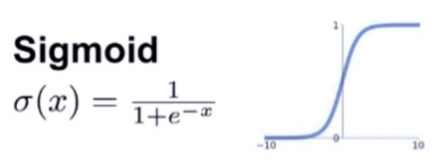

In [ ]:
# Funcion general para aplicar cualquier función de activacion 
def activation(x, f):
    return f(x)

# Funcion de activacion sigmoidea 
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

# Funcion principal sigmoide (utilizada para backward propagation) 
def sigmoid_prime(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

## Forward Propagation (propagación)

In [ ]:
# Calcular los pesos antes de aplicar la funcion de activacion
def preforward(x, w, b):
    return np.dot(x, w) + b

# Calcular los pesos despues de aplicar la funcion de activacion
# Es equivalente a la prediccion una vez que se ha entrenado el modelo 
def predict(x, W1, B1, W2, B2):
    return sigmoid(preforward(sigmoid(preforward(x , W1, B1)), W2, B2))

## Backward Propagation (retropropagación)




In [ ]:
# Calcular la derivada del error con respecto a B1
def derivativeB1(h_h, dB2, W2, f_prime):
    return np.dot(dB2, W2.T) * f_prime(h_h)

# Calcular la derivada del error con respecto a W1
def derivativeW1(x, dB1):
    return np.dot(x.T, dB1)
    
# Calcular la derivada del error con respecto a B2 
def derivativeB2(y_pred, y_true, y_h, f_prime):
    return (y_pred - y_true) * f_prime(y_h)

# Calcular la derivada del error con respecto a W2 
def derivativeW2(h, dB2):
    return np.dot(h.T, dB2)

## Funciones Evaluación

In [ ]:
#obtener la matriz de confucion
def get_metrics(pred, true):
    cm = multilabel_confusion_matrix(true, pred)
    return (cm)

# Funcion de error cuadratico medio
def sse(y_pred, y_true):
    return 0.5 * np.sum(np.power(y_pred - y_true, 2))

#4. Entrenamiento (Mini Batch Implementation)

```
 Notaciones
    x ->Imagen de entrada de shape (1, 784)
    y* -> Etiqueta one hot de shape (1, 2)
    h^ -> Propagacion de la capa de entrada a la capa oculta antes de aplicar la funcion de activacion (1, 64) usando los parametros W1, B1
    h -> Propagacion de la capa de entrada a la capa oculta despues de aplicar la funcion de activacion de simoid (1, 64)
    y^ -> Propagacion de la capa oculta a la capa de salida antes de aplicar la funcion de activacion (1,2) usando los parametros W2, B2
    y -> Propagacion de la capa oculta a la capa de salida despues de aplicar ;la funcion de activacion sigmoid (1,2)
    E -> Error entre y e y* usando error cuadratico medio 
    Acc -> 1 es la predicción correcta, 0 es la prediccion incorrecta 
    DE/D -> Derivada parcial del Error con respecto a los parámetros (B2, W2, B1, W1)
    
    Propagacion(-->)
    map batch ([x], [y*]) a ([x], [h^],[y*])
    map batch ([x], [h^],[y*]) a ([x], [h^], [h], [y*])
    map batch ([x], [h^], [h], [y*]) a ([x], [h^], [h], [y^], [y*])
    map batch ([x], [h^], [h], [y^], [y*]) a ([x], [h^], [h], [y^], [y], [y*])
    
    Retropropagacion(<--)
    map batch ([x], [h^], [h], [y^], [y], [y*]) a ([x], [h^], [h], [E], [DE/DB2], [Acc])
    map batch ([x], [h^], [h], [E], [DE/DB2], [Acc]) a ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc])
    map batch ([x], [h^], [E], [DE/DB2], [DE/DW2], [Acc]) a ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc])
    map batch ([x], [E], [DE/DB2], [DE/DW2], [DE/DB1], [Acc]) a ([E], [DE/DB2], [DE/DW2], [DE/DB1], [DE/DW1],[Acc])
```

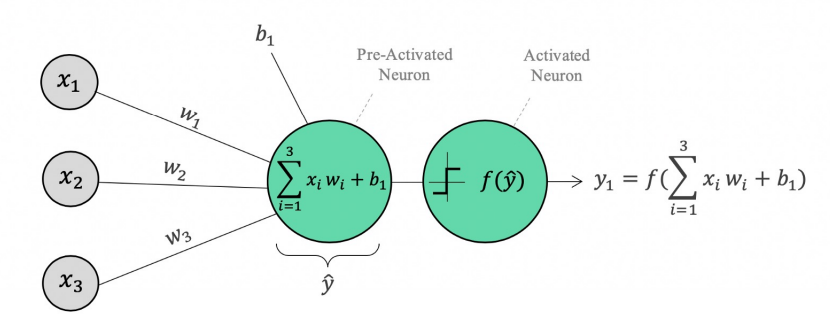

In [ ]:
# Hiperparametros 
num_iteration = 50 # numero de epocas
learningRate = 0.1 #taza de aprendizaje

input_layer = 784 # numero de neuronas en la capa de entrada (igual al tamaño de la imagen) 
hidden_layer = 64 # numero de neuronas en la capa oculta
output_layer = 2 # numero de neuronas en la capa de salida (igual al número de etiquetas posibles) 


# Inicializacion de parámetros 
W1 = np.random.rand(input_layer, hidden_layer) - 0.5 # Shape (784, 64)
W2 = np.random.rand(hidden_layer, output_layer) - 0.5 # Shape (64, 2)
B1 = np.random.rand(1, hidden_layer) - 0.5 # Shape (1, 64)
B2 = np.random.rand(1, output_layer) - 0.5 # Shape (1, 2)

# Registro de los costos y precision
cost_history = []
acc_history = []

# inciar entrenamiento
for i in range(num_iteration):
    
    # Calcular gradientes, costo y precisión en mini batch(lotes)
    gradientCostAcc = train_rdd\
                        .sample(False,0.7)\
                        .map(lambda x: (x[0], preforward(x[0], W1, B1), x[1]))\
                        .map(lambda x: (x[0], x[1], activation(x[1], sigmoid), x[2]))\
                        .map(lambda x: (x[0], x[1], x[2], preforward(x[2], W2, B2), x[3]))\
                        .map(lambda x: (x[0], x[1], x[2], x[3], activation(x[3], sigmoid), x[4]))\
                        .map(lambda x: (x[0], x[1], x[2], sse(x[4], x[5]), derivativeB2(x[4], x[5], x[3], sigmoid_prime), int(np.argmax(x[4]) == np.argmax(x[5]))))\
                        .map(lambda x: (x[0], x[1], x[3], x[4],  derivativeW2(x[2], x[4]) ,x[5]))\
                        .map(lambda x: (x[0], x[2], x[3], x[4],  derivativeB1(x[1],  x[3], W2, sigmoid_prime) ,x[5]))\
                        .map(lambda x: (x[1], x[2], x[3], x[4], derivativeW1(x[0], x[4]) ,x[5], 1)) \
                        .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3], x[4] + y[4], x[5] + y[5], x[6] + y[6]))

    # Costo y Precisión 
    n = gradientCostAcc[-1] # numero de imágenes en el batch(lote)
    cost = gradientCostAcc[0]/n # Costo sobre el batch (lote)
    acc = gradientCostAcc[5]/n # Precision sobre el batch (lote)
    
     # Agregar al registro de costo y precision
    cost_history.append(cost)
    acc_history.append(acc)
    
    # Obtener gradientes
    DB2 = gradientCostAcc[1]/n
    DW2 = gradientCostAcc[2]/n
    DB1 = gradientCostAcc[3]/n
    DW1 = gradientCostAcc[4]/n
            
    # Actualicar el parametro con la taza de aprendizaje usando gradiente descendente 
    B2 -= learningRate * DB2
    W2 -= learningRate * DW2
    B1 -= learningRate * DB1
    W1 -= learningRate * DW1

    print(f"   Epoch {i+1}/{num_iteration} | Loss: {cost_history[i]} | Acc: {acc_history[i]*100} | Batchsize:{n}")
print("Entrenamiento terminado")

   Epoch 1/50 | Loss: 0.3196605244444178 | Acc: 48.661364400134424 | Batchsize:8927
   Epoch 2/50 | Loss: 0.3077030680294082 | Acc: 49.457872148181615 | Batchsize:8854
   Epoch 3/50 | Loss: 0.2974366744693203 | Acc: 50.58571750394233 | Batchsize:8878
   Epoch 4/50 | Loss: 0.28988623333885044 | Acc: 51.28436232537179 | Batchsize:8876
   Epoch 5/50 | Loss: 0.2808786077970937 | Acc: 52.90821472598902 | Batchsize:8923
   Epoch 6/50 | Loss: 0.2722681844185689 | Acc: 55.76203966005666 | Batchsize:8825
   Epoch 7/50 | Loss: 0.2634562765061067 | Acc: 59.09603246167718 | Batchsize:8872
   Epoch 8/50 | Loss: 0.25570184871678703 | Acc: 62.13197969543147 | Batchsize:8865
   Epoch 9/50 | Loss: 0.2481393624196621 | Acc: 65.33923303834808 | Batchsize:8814
   Epoch 10/50 | Loss: 0.24070163921600324 | Acc: 69.1500055847202 | Batchsize:8953
   Epoch 11/50 | Loss: 0.2344478335684212 | Acc: 72.22789694699807 | Batchsize:8811
   Epoch 12/50 | Loss: 0.2278438099294252 | Acc: 74.67700258397933 | Batchsize:89

##Gráficas del Loss y Accuracy

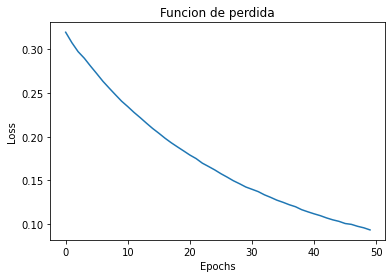

In [ ]:
# Grafica de costo sobre epocas 
plt.title("Funcion de perdida")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(cost_history)
plt.show()

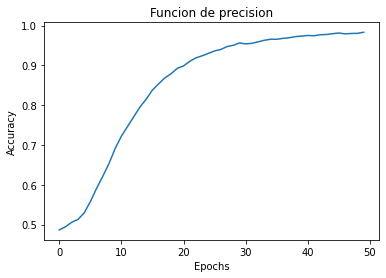

In [ ]:
# Grafico de precisión sobre epocas 
plt.title("Funcion de precision")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc_history)
plt.show()

#5. Evaluación

In [ ]:
# Usar el modelo entrenado sobre Testset y obtener la matriz de confusion por clase 
metrics = test_rdd.map(lambda x: get_metrics(np.round(predict(x[0], W1, B1, W2, B2)), x[1])).reduce(lambda x, y: x + y)

# Para cada clase, proporcione TP (Verdadero Positivo), FP(Falso Positivo), FN(Falso Negativo), TN(Verdadero Negativo) y Accuracy, y recall, y score F1 
for label, label_metrics in enumerate(metrics):
    
    print(f"\n---- Digito {label} ------")
    tn, fp, fn, tp = label_metrics.ravel()
    print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)

    precision = tp / (tp + fp + 0.000001)
    print(f"\Accuracy : {precision}")

    recall = tp / (tp + fn + 0.000001)
    print(f"Recall: {recall}")

    F1 = 2 * (precision * recall) / (precision + recall + 0.000001)
    print(f"F1 score: {F1}")


---- Digito 0 ------
TP: 898 FP: 29 FN: 82 TN: 1106
\Accuracy : 0.9687162880596373
Recall: 0.9163265296772178
F1 score: 0.9417928921622527

---- Digito 1 ------
TP: 1128 FP: 67 FN: 7 TN: 913
\Accuracy : 0.9439330536034032
Recall: 0.9938325982433192
F1 score: 0.9682398428483485


#6. Predicción

prediccion: 0, probabilidad: 0.67 


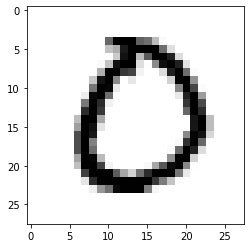

prediccion: 1, probabilidad: 0.82 


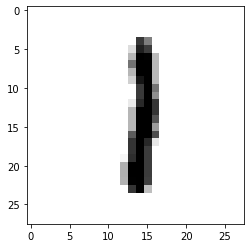

prediccion: 1, probabilidad: 0.86 


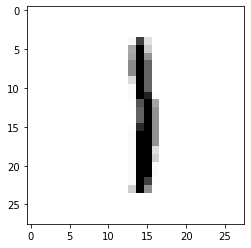

prediccion: 1, probabilidad: 0.78 


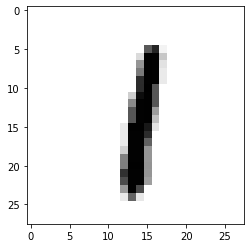

prediccion: 0, probabilidad: 0.73 


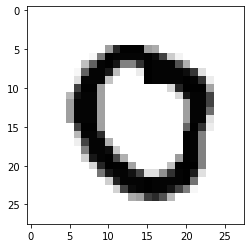

prediccion: 1, probabilidad: 0.73 


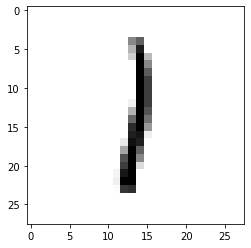

prediccion: 1, probabilidad: 0.66 


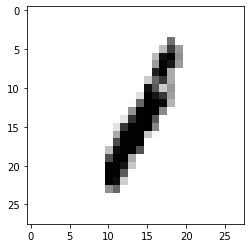

prediccion: 0, probabilidad: 0.7 


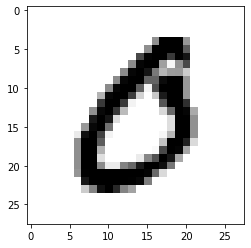

prediccion: 0, probabilidad: 0.61 


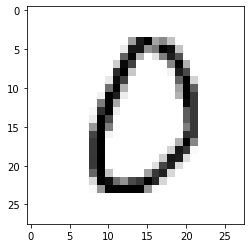

prediccion: 1, probabilidad: 0.55 


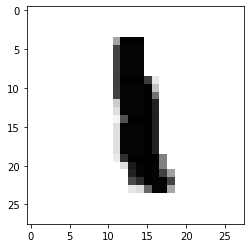

prediccion: 1, probabilidad: 0.79 


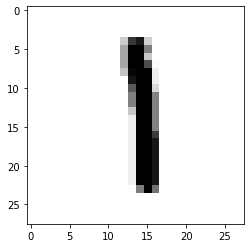

prediccion: 1, probabilidad: 0.82 


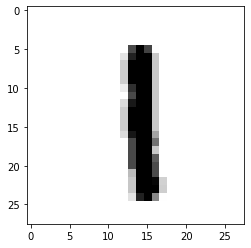

prediccion: 1, probabilidad: 0.75 


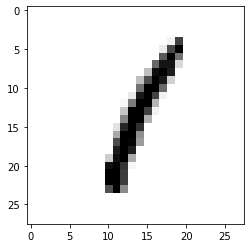

prediccion: 1, probabilidad: 0.75 


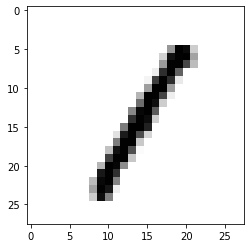

prediccion: 1, probabilidad: 0.48 


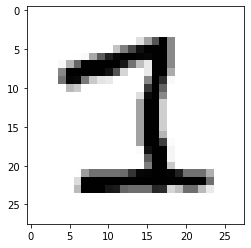

In [ ]:
for image_test in test_rdd.map(lambda x: (x[0], predict(x[0], W1, B1, W2, B2), np.argmax(x[1]))).takeSample(False, 15):
    pred = np.argmax(image_test[1])
    print(f'prediccion: {pred}, probabilidad: {round(image_test[1][0][pred], 2)} ')
    image = np.reshape(image_test[0], (28, 28))
    plt.imshow(image, cmap='binary')
    plt.show()